# Surface velocities PanAn01

In [1]:
import glob
import dask.distributed as dsk
import xesmf as xe
from pathlib import Path
import numpy as np
import xarray as xr

import xgcm
import cf_xarray

# For plotting
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import cmocean as cm
import pyproj
import cartopy.feature as cft
import glob

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

In [2]:
import logging
logging.getLogger("matplotlib").setLevel(logging.WARNING)

In [3]:
from dask.distributed import Client
client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 28
Total threads: 28,Total memory: 126.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39299,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:39525,Total threads: 1
Dashboard: /proxy/35035/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:34597,


In [4]:
# Importing data

pathsC = np.sort(glob.glob('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/*/*.ocean_month_z.nc'))
pathsM = np.sort(glob.glob('/g/data/g40/akm157/model_output/mom6-panan/panant-01-zstar-ssp126-MW-only/*/*.ocean_month_z.nc'))

In [5]:
# Shelf contour
shelf_mask = xr.open_dataset('/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_01deg.nc')['contour_masked_above']

In [6]:
# Time variant variables
def preprocess(ds):
    ds = ds[['uo', 'vo']].isel(z_l=0) # Taking just the surface
    return ds

cont = xr.open_mfdataset(pathsC, preprocess = preprocess, chunks = 'auto')
melt = xr.open_mfdataset(pathsM, preprocess = preprocess, chunks = 'auto')

In [7]:
# Time slicing
# Last 5 years only for anomaly maps
cont = cont.sel(time=slice('2006-01-01','2010-12-31')).mean(dim='time')
melt = melt.sel(time=slice('2006-01-01','2010-12-31')).mean(dim='time')

In [8]:
uo_C = cont['uo']
vo_C = cont['vo']
uo_M = melt['uo']
vo_M = melt['vo']

In [9]:
cont_n = xr.merge([uo_C,vo_C])
cont_n= cont_n.isel(xq = slice(1, None), yq = slice(1, None))
pert_n = xr.merge([uo_M,vo_M])
pert_n= pert_n.isel(xq = slice(1, None), yq = slice(1, None))

In [10]:
path_to_ocean_static_M = Path('/g/data/g40/akm157/model_output/mom6-panan/panant-01-zstar-ssp126-MW-only/output021/20010701.ocean_static.nc')
ocean_static_M = xr.open_dataset(path_to_ocean_static_M)

path_to_ocean_static_C = Path('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output021/20000701.ocean_static.nc')
ocean_static_C = xr.open_dataset(path_to_ocean_static_C)

In [11]:
ocean_static_M = ocean_static_M.sel(xq = pert_n['xq'], xh = pert_n['xh'], yq = pert_n['yq'], yh = pert_n['yh'])

grid_M = xgcm.Grid(ocean_static_M, coords = {'X': {'center': 'xh', 'right': 'xq'},
                                     'Y': {'center': 'yh', 'right': 'yq'}},
                                   periodic = ['X'])

ocean_static_C = ocean_static_C.sel(xq = cont_n['xq'], xh = cont_n['xh'], yq = cont_n['yq'], yh = cont_n['yh'])

grid_C = xgcm.Grid(ocean_static_C, coords = {'X': {'center': 'xh', 'right': 'xq'},
                                     'Y': {'center': 'yh', 'right': 'yq'}},
                                   periodic = ['X'])

In [12]:
u_int_C = grid_C.interp(cont_n['uo'], 'X')
v_int_C = grid_C.interp(cont_n['vo'], 'Y')
u_int_M = grid_M.interp(pert_n['uo'], 'X')
v_int_M = grid_M.interp(pert_n['vo'], 'Y')

In [13]:
u_int_C

<xarray.DataArray 'uo' (yh: 845, xh: 3600)> Size: 12MB
dask.array<interp_right_to_center, shape=(845, 3600), dtype=float32, chunksize=(242, 1030), chunktype=numpy.ndarray>
Coordinates:
  * xh       (xh) float64 29kB -279.9 -279.8 -279.7 -279.6 ... 79.75 79.85 79.95
  * yh       (yh) float64 7kB -81.11 -81.07 -81.02 ... -37.3 -37.22 -37.14

In [14]:
v_int_C

<xarray.DataArray 'vo' (yh: 845, xh: 3600)> Size: 12MB
dask.array<transpose, shape=(845, 3600), dtype=float32, chunksize=(242, 1030), chunktype=numpy.ndarray>
Coordinates:
  * xh       (xh) float64 29kB -279.9 -279.8 -279.7 -279.6 ... 79.75 79.85 79.95
  * yh       (yh) float64 7kB -81.11 -81.07 -81.02 ... -37.3 -37.22 -37.14

In [15]:
u_int_M

<xarray.DataArray 'uo' (yh: 845, xh: 3600)> Size: 12MB
dask.array<interp_right_to_center, shape=(845, 3600), dtype=float32, chunksize=(242, 1030), chunktype=numpy.ndarray>
Coordinates:
  * xh       (xh) float64 29kB -279.9 -279.8 -279.7 -279.6 ... 79.75 79.85 79.95
  * yh       (yh) float64 7kB -81.11 -81.07 -81.02 ... -37.3 -37.22 -37.14

In [16]:
v_int_M

<xarray.DataArray 'vo' (yh: 845, xh: 3600)> Size: 12MB
dask.array<transpose, shape=(845, 3600), dtype=float32, chunksize=(242, 1030), chunktype=numpy.ndarray>
Coordinates:
  * xh       (xh) float64 29kB -279.9 -279.8 -279.7 -279.6 ... 79.75 79.85 79.95
  * yh       (yh) float64 7kB -81.11 -81.07 -81.02 ... -37.3 -37.22 -37.14

In [17]:
abs_C = np.sqrt(u_int_C**2 + v_int_C**2)
abs_M = np.sqrt(u_int_M**2 + v_int_M**2)

In [18]:
abs_anom = abs_M - abs_C
abs_anom

<xarray.DataArray (yh: 845, xh: 3600)> Size: 12MB
dask.array<sub, shape=(845, 3600), dtype=float32, chunksize=(241, 1029), chunktype=numpy.ndarray>
Coordinates:
  * xh       (xh) float64 29kB -279.9 -279.8 -279.7 -279.6 ... 79.75 79.85 79.95
  * yh       (yh) float64 7kB -81.11 -81.07 -81.02 ... -37.3 -37.22 -37.14

In [19]:
abs_C = abs_C.load()

In [20]:
abs_C.to_netcdf('/g/data/g40/kc5856/thesis_figures/data_files/surface_velocity_map_control_Pan01.nc')

In [19]:
abs_anom = abs_anom.load()

In [20]:
abs_anom.to_netcdf('/g/data/g40/kc5856/thesis_figures/data_files/surface_velocity_map_Pan01.nc')

## Plotting

In [33]:
depth = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output050/20050501.ocean_static.nc')['deptho']
land_mask = (0 * depth).fillna(1)
land = xr.where(np.isnan(depth.rename('land')), 1, np.nan)

In [22]:
# Create a mask: True where depth is greater (deeper) than 3000m (or less if bathy is negative)
mask_3000m = depth > 3000  # or bathy < -3000 depending on bathy convention (usually negative)

# Mask your data array (abs_anom) where bathy is deeper than 3000m
import numpy as np
abs_anom_masked = abs_anom.where(~mask_3000m).fillna(0)  # keep data only shallower or equal to 3000m

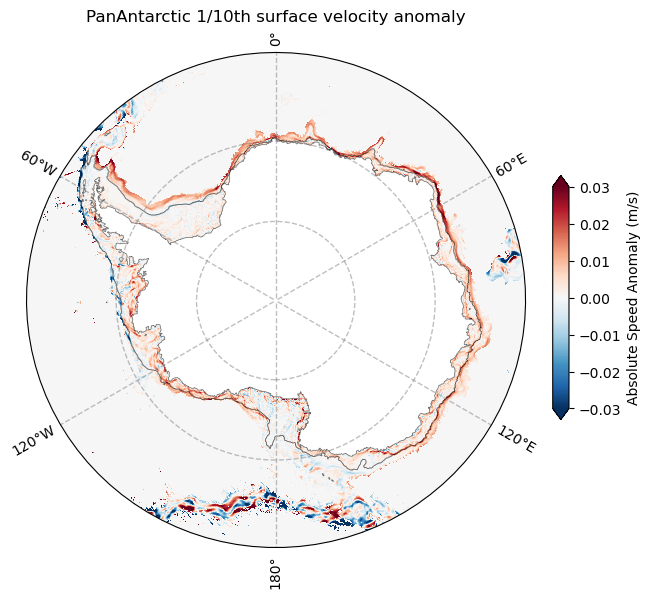

In [23]:
projection = ccrs.SouthPolarStereo()
    
plt.figure(figsize=(7, 8))
ax = plt.axes(projection=projection)
ax.set_extent([-280, 80, -80, -59], crs=ccrs.PlateCarree())
    
# Circular boundary
theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5,0.495], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

# Filled land 
land.plot.contourf(ax=ax, colors='white',
                   zorder=2,
                   transform=ccrs.PlateCarree(),
                   add_colorbar=False)

# Coast line
ax.contour(land_mask.cf['X'], land_mask.cf['Y'], land_mask,
           levels = [0, 1], colors = 'dimgrey',linewidths=0.5, transform = ccrs.PlateCarree())
# Shelf contour
ax.contour(shelf_mask.cf['X'], shelf_mask.cf['Y'], shelf_mask,
           levels = [0, 1], colors = 'k', linewidths=0.1,transform = ccrs.PlateCarree())

# Adding polar axes
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, 
                    xlocs=range(-180,171,60), ylocs=[], 
                    color='gray', alpha=0.5, linestyle='--', zorder=10)
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1, 
                    xlocs=[], ylocs=(-80,-70,-55), 
                    color='gray', alpha=0.5, linestyle='--', zorder=10)

# Plotting
abs_anom_masked .plot(
    x="xh",
    y="yh",
    transform=ccrs.PlateCarree(),
    vmin=-0.03,
    vmax=0.03,
    extend="both",
    cmap=plt.get_cmap('RdBu').reversed(), #cm ocean colour maps for more options, matplotlib has more also.
    cbar_kwargs={"label": "Absolute Speed Anomaly (m/s)", "fraction": 0.03, "aspect": 15, "shrink": 0.7},
);

plt.title("PanAntarctic 1/10th surface velocity anomaly");

# Dividing anomaly by control to see percentage increase

In [21]:
anomaly = xr.open_dataarray('/g/data/g40/kc5856/thesis_figures/data_files/surface_velocity_map_Pan01.nc')
control = xr.open_dataarray('/g/data/g40/kc5856/thesis_figures/data_files/surface_velocity_map_control_Pan01.nc')

In [27]:
(anomaly/control)

<xarray.DataArray (yh: 845, xh: 3600)> Size: 12MB
array([[        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       ...,
       [-0.06606974, -0.0634322 , -0.05939857, ..., -0.04609066,
        -0.05714099, -0.06433857],
       [-0.04537071, -0.04710855, -0.04471537, ..., -0.00045897,
        -0.01908968, -0.03397894],
       [ 0.00146646, -0.00236045, -0.00634358, ...,  0.04074404,
         0.03072453,  0.01754803]], dtype=float32)
Coordinates:
  * xh       (xh) float64 29kB -279.9 -279.8 -279.7 -279.6 ... 79.75 79.85 79.95
  * yh       (yh) float64 7kB -81.11 -81.07 -81.02 ... -37.3 -37.22 -37.14

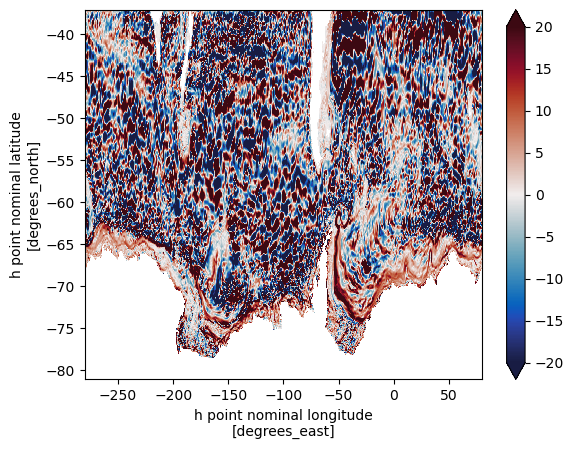

In [31]:
((anomaly/control)*100).plot(vmin=-20,vmax=20,cmap=cm.cm.balance)

In [49]:
# Create a mask: True where depth is greater (deeper) than 3000m (or less if bathy is negative)
mask_3000m = depth > 3500  # or bathy < -3000 depending on bathy convention (usually negative)

# Mask your data array (abs_anom) where bathy is deeper than 3000m
import numpy as np
anomaly_masked = anomaly.where(~mask_3000m).fillna(0)  # keep data only shallower or equal to 3000m
control_masked = control.where(~mask_3000m).fillna(0)  # keep data only shallower or equal to 3000m

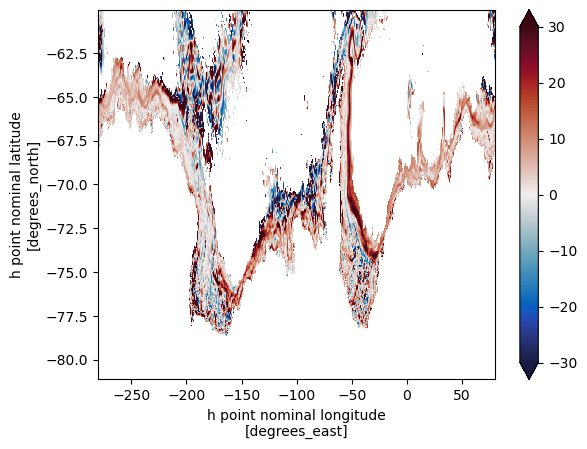

In [58]:
((anomaly_masked/control_masked)*100).sel(yh=slice(None,-60)).plot(vmin=-30,vmax=30,cmap=cm.cm.balance)

In [54]:
((anomaly_masked/control_masked)*100).sel(yh=slice(None,-65)).max()

<xarray.DataArray ()> Size: 8B
array(5391.49804688)